# PyTorch - Autograd (is what we need.)

Advanced Learning 2024





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 342766763
~~~

~~~
STUDENT GIT LINK: https://github.com/mickaelAssous/52025.git
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2024_ID_342766763.html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [13]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [14]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cuda!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [15]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.079639,1.361655,1.764152,-0.361173,-0.075996,-1.252506,-1.210522
1,-0.761850,2.296540,3.230346,-0.261858,-0.099401,-1.081451,-1.096713
2,-0.920744,-0.882436,-0.866931,-0.955326,-0.999223,-1.170071,-1.048430
3,-1.159087,-0.524171,-0.480216,-0.796769,-0.715753,-0.362590,-1.154480
4,-0.682402,-0.545731,-0.506313,-0.701809,-0.622130,-1.026424,-1.222593


We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+	\beta_1\text{housing_median_age}_i+ 	\beta_2\text{total_rooms}_i+ 	\beta_3\text{total_bedrooms}_i+ 	\beta_4\text{population}_i+ 	\beta_5\text{households}_i+ 	\beta_6\text{median_income}_i 	$$

**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [16]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']

print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [17]:
#### SOLUTION REQUIRED ####
t1 = time.time()

weights_rounded = np.round(np.linalg.inv(X.T @ X) @ X.T @ Y, 3)
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.007
The estimated weights using the analytic solution:
 [ 0.     0.204 -0.375  0.362 -0.347  0.422  0.79 ]


Visualizing the errors:

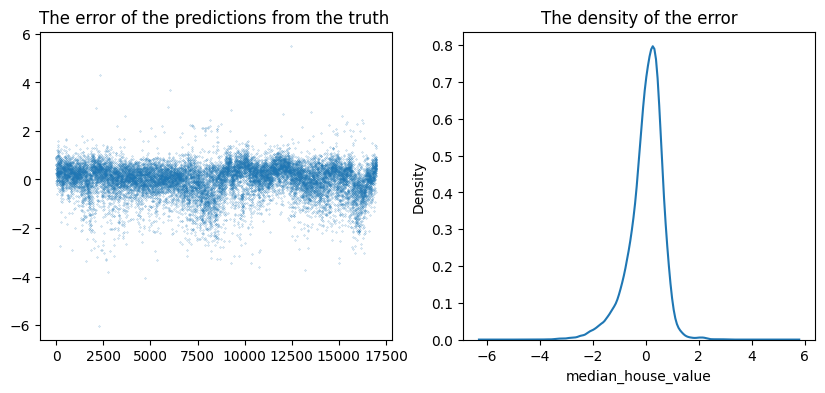

In [18]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      





In [19]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.randn()
b1 = np.random.randn()
b2 = np.random.randn()
b3 = np.random.randn()
b4 = np.random.randn()
b5 = np.random.randn()
b6 = np.random.randn()

# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 1e-4

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    Y_pred = (b0 * X[:, 0] + b1 * X[:, 1] + b2 * X[:, 2] +
              b3 * X[:, 3] + b4 * X[:, 4] + b5 * X[:, 5] +
              b6 * X[:, 6])

    # Compute and print loss
    loss = np.mean((Y - Y_pred) ** 2)
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = -2 * (Y - Y_pred) / len(Y)
    grad_b0 = np.sum(grad_y_pred * X[:, 0])
    grad_b1 = np.sum(grad_y_pred * X[:, 1])
    grad_b2 = np.sum(grad_y_pred * X[:, 2])
    grad_b3 = np.sum(grad_y_pred * X[:, 3])
    grad_b4 = np.sum(grad_y_pred * X[:, 4])
    grad_b5 = np.sum(grad_y_pred * X[:, 5])
    grad_b6 = np.sum(grad_y_pred * X[:, 6])

    # Update weights
    b0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    b4 -= learning_rate * grad_b4
    b5 -= learning_rate * grad_b5
    b6 -= learning_rate * grad_b6

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:1.738836217754011
Epoch:1000, loss:1.4470401400914987
Epoch:2000, loss:1.2976641802842213
Epoch:3000, loss:1.1986578442549567
Epoch:4000, loss:1.1246677718072882
Result: y_hat = 0.010551679940527999 x0 + -0.05133044844609845 x1 + 0.4463680880446353 x2 + -0.9114144210219692 x3
 + 1.0903392099098095 x4 + -0.6005782840883178 x5 + 0.6202704405338966 x6 

Total process time: 9.469
The estimated weights using the gradient descent solution:
 [ 0.011 -0.051  0.446 -0.911  1.09  -0.601  0.62 ]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [20]:
#### SOLUTION REQUIRED ####

# Creating data and target tensors:
tX = torch.tensor(X)
tY = torch.tensor(Y)

t3 = time.time()

# Randomly initialize weights using PyTorch
tb0 = torch.randn(1, requires_grad=True)
tb1 = torch.randn(1, requires_grad=True)
tb2 = torch.randn(1, requires_grad=True)
tb3 = torch.randn(1, requires_grad=True)
tb4 = torch.randn(1, requires_grad=True)
tb5 = torch.randn(1, requires_grad=True)
tb6 = torch.randn(1, requires_grad=True)

# Set learning rate
learning_rate = 1e-4

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    tY_pred = tb0 * tX[:, 0] + tb1 * tX[:, 1] + tb2 * tX[:, 2] + \
              tb3 * tX[:, 3] + tb4 * tX[:, 4] + tb5 * tX[:, 5] + \
              tb6 * tX[:, 6]

    # Compute and print loss
    loss = torch.mean((tY - tY_pred) ** 2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    grad_y_pred = -2 * (tY - tY_pred) / len(tY)
    # print(grad_y_pred.sum())
    grad_b0 = torch.sum(grad_y_pred * tX[:, 0])
    grad_b1 = torch.sum(grad_y_pred * tX[:, 1])
    grad_b2 = torch.sum(grad_y_pred * tX[:, 2])
    grad_b3 = torch.sum(grad_y_pred * tX[:, 3])
    grad_b4 = torch.sum(grad_y_pred * tX[:, 4])
    grad_b5 = torch.sum(grad_y_pred * tX[:, 5])
    grad_b6 = torch.sum(grad_y_pred * tX[:, 6])

    # Update weights
    tb0 = tb0 - learning_rate * grad_b0
    tb1 = tb1 - learning_rate * grad_b1
    tb2 = tb2 - learning_rate * grad_b2
    tb3 = tb3 - learning_rate * grad_b3
    tb4 = tb4 - learning_rate * grad_b4
    tb5 = tb5 - learning_rate * grad_b5
    tb6 = tb6 - learning_rate * grad_b6

print(f"Result: y_hat = {tb0} x0 + {tb1} x1 + {tb2} x2 + {tb3} x3\n + {tb4} x4 + {tb5} x5 + {tb6} x6 \n")
print(f"Total process time: {round(time.time() - t3,3)}")

weights_gd_tensors_rounded = np.array([tb0.item(),tb1.item(),tb2.item(),tb3.item(),
                                       tb4.item(),tb5.item(),tb6.item()])
print(f"The estimated weights using the gradient descent on tensors:\n {weights_gd_tensors_rounded.round(3)}")

epoch:0, loss:8.538331487754133
epoch:1000, loss:4.721954300997917
epoch:2000, loss:3.066903670844165
epoch:3000, loss:2.155664665658984
epoch:4000, loss:1.5911436316542604
Result: y_hat = tensor([0.3421], device='cuda:0', grad_fn=<SubBackward0>) x0 + tensor([0.1438], device='cuda:0', grad_fn=<SubBackward0>) x1 + tensor([-0.9892], device='cuda:0', grad_fn=<SubBackward0>) x2 + tensor([2.0310], device='cuda:0', grad_fn=<SubBackward0>) x3
 + tensor([-0.3335], device='cuda:0', grad_fn=<SubBackward0>) x4 + tensor([-0.5932], device='cuda:0', grad_fn=<SubBackward0>) x5 + tensor([0.1704], device='cuda:0', grad_fn=<SubBackward0>) x6 

Total process time: 6.222
The estimated weights using the gradient descent on tensors:
 [ 0.342  0.144 -0.989  2.031 -0.333 -0.593  0.17 ]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [21]:
# FILL IN THE MISSING CODE

t4 = time.time()

# Randomly initialize weights using PyTorch
# we can use 1x7 tensor for all the weights. Make sure `requires_grad = True`.
tb = torch.randn(7, requires_grad=True)


# Set learning rate
learning_rate = 1e-4
# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = torch.sum(tX * tb, dim=1)

    # Compute and print loss
    loss = torch.mean((tY - tY_pred) ** 2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop to compute gradients of betas with respect to loss
    loss.backward()

    with torch.no_grad():
        # Update weights
        tb -= learning_rate * tb.grad
        tb.grad = None # manually clear gradient after update


print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:2.6829069646710164
epoch:1000, loss:1.8613418788018736
epoch:2000, loss:1.5042191337474846
epoch:3000, loss:1.2987058670219418
epoch:4000, loss:1.1613446886504706
Result: betas = tensor([ 0.2173,  0.0713, -0.7157, -1.0749,  1.0866,  0.7640,  0.5361],
       device='cuda:0', requires_grad=True) 

Total process time: 3.278
The estimated weights using the pytorch autograd:
 [ 0.217  0.071 -0.716 -1.075  1.087  0.764  0.536]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1. The most theoretically precise method for finding the "true" weights is the one based on linear algebra, such as solving the system of equations directly. However, PyTorch Autograd might offer higher practical accuracy because it automatically calculates gradients, minimizing the risk of human error in coding (no need for manual differentiation). This makes it reliable for more complex problems.

2. Scaling the data ensures that all variables have a similar range. For gradient descent algorithms, unscaled data can create problems when some variables have large values (e.g., thousands) while others are much smaller (e.g., 0.1). This imbalance confuses the model, as the larger values dominate the optimization process, slowing down training and making convergence less stable. Scaling ensures all features contribute equally, leading to faster, more stable convergence and better initial weight adjustments.

3. The results are not perfect, mainly due to the absence of regularization. Regularization techniques like Ridge (L2) or Lasso (L1) were not implemented, which can lead to overfitting or extreme weight values when the data is not perfectly clean. Furthermore, the assumption of a linear relationship between the variables may not hold, which could also degrade model performance.

4. Numpy: This method is the slowest because it involves manual gradient calculations without the benefit of optimized libraries.
PyTorch without Autograd: Faster than Numpy since PyTorch is optimized for computational efficiency, even with manual gradient calculations.
PyTorch with Autograd: The fastest and most efficient method. Its automatic differentiation eliminates human error and speeds up the entire process, making it ideal for complex problems.
   
5. Adding regularization techniques like Ridge (L2) or Lasso (L1) could prevent overfitting by penalizing extreme or unnecessary weights. Another improvement would be to verify that the relationship between the features (X) and the target variable (Y) is linear. If it is not, introducing polynomial features or using a non-linear model could provide better results.

6. Replacing simple gradient descent with advanced optimization algorithms like Adam could improve both the speed and stability of convergence. Adam adapts the learning rate for each parameter dynamically, making it more efficient for problems with complex loss landscapes. This would likely reduce training time and improve performance.



PART 2: Coming soon...

In [ ]:
!jupyter nbconvert --to html /PS1_Part3_Autograd_2024_ID_342766763.ipynb